# Clean up for your vacation images

In [1]:
# Define global variables, are explained below

IMAGES = './images/' # path to the images
IMAGES_PREPROCESSED = './preprocessed/' # not used at the moment
IMAGES_PROCESSED = './processed/' # output destination
HASH_DIM = (8, 8)

In [2]:
import glob
import os
import shutil

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as sts
from sklearn.linear_model import LogisticRegression

import spring_cleaning as sc # outsourced code

# Pipeline

In [3]:
# Load images and meta data

dict_files = sc.read_files(path=IMAGES, ext='jpg')

df = pd.DataFrame(dict_files, columns=['file', 'creation_date'])
df['creation_date'] = pd.to_numeric(df['creation_date'], downcast='integer')

# For ranking of images, we need some intrinsic measure for consecutiveness
# 'Creation Date' of images is a good measure
# 'File Name' as well, if pictures are taken from one and the same camera

# alternatively, sort by Filename: df.sort_values(by=['File'])
df = df.sort_values(by=['creation_date'])
df['timediff_value'] = df['creation_date'].diff(-1).abs()

# Load images
df['gray_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='gray')) 
                                            for cur_file in df['file'].values]

df['hsv_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='hsv')) 
                                            for cur_file in df['file'].values]

df[[c for c in df.columns if not c.endswith('_images')]].head()

,file,creation_date,timediff_value
23,ar_1.JPG,1487935036,0.0
22,ar_0.JPG,1487935036,16.0
25,as_1.JPG,1487935052,0.0
24,as_0.JPG,1487935052,10.0
26,at_0.JPG,1487935062,2.0


In [4]:
# Assign labels
df = df.assign(target = df['file'].str.split(n=0, pat='_', expand=True).loc[:, 0])
df['target'], _ = pd.factorize(df['target'])
df['target'] = df['target'] + 1
n_img = len(df['target'].unique())

# perfect performance output 
sc.calculate_performance(df['target'], df['target'], n_img)

(20, 20, 20, 1.0)

In [5]:
# Rank by time
# useful, if sequences of images are shot

df['timediff_rank'] = sc.timelag_ranker(df['timediff_value'])

In [6]:
# Rank by image hash

df['hash_value'] = sc.compare_hashes_adv(df['gray_images'], return_hash_only=True)
df['hash_rank'] = sc.hash_ranker(df['hash_value'], HASH_DIM)

df['hash_adv_value'] = sc.compare_hashes_adv(df['gray_images'])
df['hash_adv_rank'] = sc.hash_ranker(df['hash_adv_value'], HASH_DIM, 0.95)

In [7]:
# Rank by correlation of image histograms

df['correl_corr'] = sc.calc_correlations(df['hsv_images'], 'correl')
df['correl_rank'] = sc.corr_ranker(df['correl_corr'])

df['bhattacharyya_corr'] = sc.calc_correlations(df['hsv_images'], 'bhattacharyya')
df['bhattacharyya_rank'] = sc.corr_ranker(df['bhattacharyya_corr'])

In [8]:
# Rank by axis-ratio change

df['axisratio_value'] = df['gray_images'].apply(lambda x: sc.calculate_axis_ratio(x)).diff(-1).fillna(0)
df['axisratio_rank'] = sc.img_shape_ranker(df['axisratio_value'])

In [9]:
# Create ranks from ensemble of methods

voting_col = [col for col in df.columns if col.endswith('_rank') and not col.endswith('voting_rank')]
df['voting_diff'] = df[voting_col].diff(-1).fillna(-1).apply(lambda x: 1 + np.mean(x), axis=1)
df['voting_rank'] = sc.vote_ranker(df['voting_diff'])

# Performance summary - Ranker

In [10]:
evals = {col: sc.calculate_performance(df['target'], df[col], n_img) 
             for col in voting_col + ['voting_rank', 'target']
}
df_eval = pd.DataFrame.from_dict(evals, orient='index', 
            columns=['groups_found', 'groups_unique', 'groups_true', 'reduction']
            ).sort_values(by=['reduction'])

df_eval

,groups_found,groups_unique,groups_true,reduction
axisratio_rank,0,5,20,0.00
voting_rank,19,20,20,0.95
target,20,20,20,1.00
timediff_rank,20,21,20,1.05
correl_rank,20,22,20,1.10
hash_rank,20,24,20,1.20
hash_adv_rank,20,26,20,1.30
bhattacharyya_rank,20,26,20,1.30


Text(0.5, 1.0, 'Images identified by different ranking methods\n')

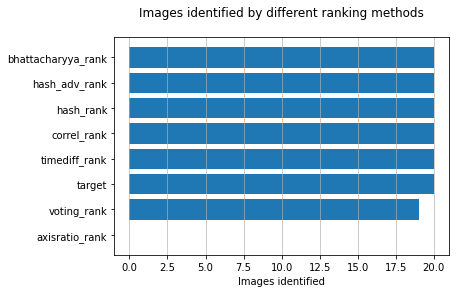

In [11]:
plt.barh(df_eval.index, df_eval['groups_found'])
plt.xlim([df_eval['groups_found'].min()-1, df_eval['groups_found'].max()+1])
plt.grid(which='major', axis='x', alpha=0.8)
plt.xlabel('Images identified')
plt.title('Images identified by different ranking methods\n')

Text(0.5, 1.0, 'Reduction by different ranking methods\n')

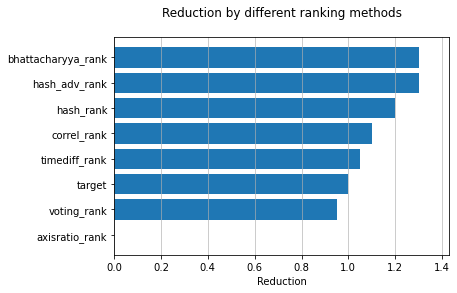

In [12]:
plt.barh(df_eval.index, df_eval['reduction'])
plt.xlim([df_eval['reduction'].min()*0.9, df_eval['reduction'].max()*1.1])
plt.grid(which='major', axis='x', alpha=0.8)
plt.xlabel('Reduction')
plt.title('Reduction by different ranking methods\n')

# Identify the best images: high-pass filtering

In [13]:
df['magnitude_spectrum_f'] = df['gray_images'].apply(lambda x: sc.high_pass_filtering(x))

# Apply results

In [14]:
# Finally, copy the images into ready-to-go directory, that's it!

sc.copy_images(df, (IMAGES, IMAGES_PROCESSED), 'voting_rank', 'magnitude_spectrum_f')